# ML Ops project description

You are working as an ML Ops Engineer in a multi-disciplinary product-oriented pod developing ML-based application.
You have received this notebook from a Data Scientist.
Your task is to prepare the model training code for being run in production environment.

You will need to make reproducible the model training, testing and validation code from this notebook. You will also need to decide which parts of the notebook code are relevant.

Please note that in this exercise fetching of the data from DB is mocked.

What we would like to see:
- code organised in a GitHub repository with README
- GitHub action to assess the code quality
- GitHub action to run the model training with validation in Docker container

Extra points (if you have time) - either to be included as a discussion or implementation:
- how to track and compare model training metrics across different training runs?
- how to perform versioning of different models trained?
- how to perform model deployment for real-time predictions serving?


Please don't plan more than 3 hours for this exercise as we value your time.

# Project: Training an image Classifier


# 0. Prerequisites


In [ ]:
!pip install torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 834.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 2.6 MB/s eta 0:00:00


In [ ]:
%matplotlib inline

In [ ]:
!ls -la ./data/cifar-10-batches-py/

total 181884
drwxr-xr-x 2 2156 1103     4096 Jun  4  2009 .
drwxr-xr-x 3 root root     4096 Mar 18 10:16 ..
-rw-r--r-- 1 2156 1103      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 31035526 Mar 31  2009 test_batch


In [ ]:
TRAINING_DATA_PATH = './data'
MODEL_OUTPUT_PATH = './model.pth'

## 1. Loading and normalizing dataset


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
def get_train_test_data_loader(db_host, db_name, db_user, db_pass):
    """
    For the purpose of this exercice, this function is here to simulate a call to a database.
    You can keep it like that but keep in mind in a real situation, here you would have the code for db communication.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root=TRAINING_DATA_PATH,
                                            train=True,
                                            download=True,
                                            transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=TRAINING_DATA_PATH,
                                          train=False,
                                          download=True,
                                          transform=transform)
    testloader = torch.utils.data.DataLoader(testset,
                                            batch_size=4,
                                            shuffle=False,
                                            num_workers=2)

    return trainloader, testloader


In [ ]:
trainloader, testloader = get_train_test_data_loader('127.0.0.1', 'localdb', 'DB_USER_ANALYSIS', 'ZA68eWqt8VWBTQwPBrpI')

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Helper functions to visualize the images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


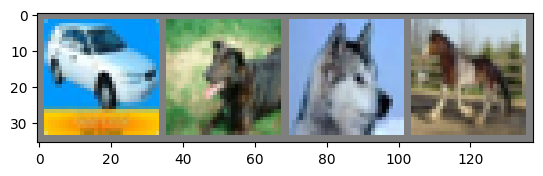

  car   dog   dog horse


In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## 3. Define a Loss function and optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


## 4. Train the model

Depending on the hardware, pick a specific device to run the model training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.216
[1,  4000] loss: 1.840
[1,  6000] loss: 1.666
[1,  8000] loss: 1.585
[1, 10000] loss: 1.522
[1, 12000] loss: 1.480
[2,  2000] loss: 1.425
[2,  4000] loss: 1.382
[2,  6000] loss: 1.374
[2,  8000] loss: 1.347
[2, 10000] loss: 1.332
[2, 12000] loss: 1.336
Finished Training


Save the model to be reused later

In [ ]:
torch.save(net.state_dict(), MODEL_OUTPUT_PATH)

## 5. Test the network on the test data

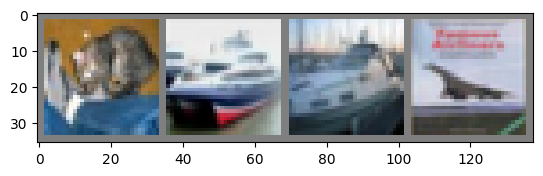

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


Load the saved model

In [ ]:
net = Net()
net.load_state_dict(torch.load(MODEL_OUTPUT_PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship  ship


Check how the network performs on the whole dataset.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


Check what are the classes that performed well, and the classes that did not.

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 69 %
Accuracy of  bird : 36 %
Accuracy of   cat : 58 %
Accuracy of  deer : 60 %
Accuracy of   dog : 30 %
Accuracy of  frog : 33 %
Accuracy of horse : 64 %
Accuracy of  ship : 65 %
Accuracy of truck : 50 %
